<h2> 데이터 베이스 연결 및 테이블 생성 <h2>

In [1]:
import psycopg2
connection = psycopg2.connect(database="pythonspatial",user="postgres", password="****")
cursor = connection.cursor()
cursor.execute("CREATE TABLE art_pieces (id SERIAL PRIMARY KEY, code VARCHAR(255), location GEOMETRY)")
connection.commit()

<h2> 테이블에 데이터 추가 <h2>

https://opendata.cabq.gov/dataset/public-art

In [2]:
import json
with open('/study/data/PublicArt.json', 'r') as f:
    data = json.load(f)
data["features"][0]

{'attributes': {'OBJECTID': 991405,
  'ART_CODE': '101',
  'TITLE': 'Almond Blossom/Astronomy',
  'TYPE': 'public sculpture',
  'YEAR': '1986',
  'ARTIST': 'David Anderson',
  'ADDRESS': '4440 Osuna NE',
  'LOCATION': 'Osuna Median bet.Jefferson/ W.Frontage Rd',
  'X': -106.5918383,
  'Y': 35.1555,
  'IMAGE_URL': 'http://www.flickr.com/photos/abqpublicart/6831137393/',
  'JPG_URL': 'http://farm8.staticflickr.com/7153/6831137393_fa38634fd7_m.jpg'},
 'geometry': {'x': -11865749.1623, 'y': 4185033.1033999994}}

In [3]:
### DB에 점 생성
for a in data["features"]:    
    code=a["attributes"]["ART_CODE"]    
    wkt="POINT("+str(a["geometry"]["x"])+" "+str(a["geometry"]["y"])+")"    
    if a["geometry"]["x"]=='NaN':        
        pass    
    else:        
        cursor.execute("INSERT INTO art_pieces (code, location) VALUES ({},ST_GeomFromText('{}'))".format(code, wkt))
    connection.commit()

<h2> shapely <h2>

In [4]:
### shapely로 geometry 만들기
from shapely.geometry import Point, MultiPoint
thepoints=[]
for a in data["features"]:    
    code=a["attributes"]["ART_CODE"]    
    p=Point(float(a["geometry"]["x"]),float(a["geometry"]["y"]))    
    thepoints.append(p)    
    if a["geometry"]["x"]=='NaN':        
        pass    
    else:        
        cursor.execute("INSERT INTO art_pieces (code, location) VALUES ('{}', ST_GeomFromText('{}'))".format(code, p.wkt))
connection.commit() 

<h2> 데이터 쿼리하기 <h2>

In [5]:
### SELECT all
cursor.execute("SELECT * from art_pieces") 
data=cursor.fetchall() 
data

[(1, '101', '0101000000C58F31A5D2A166C110363C8DE4ED4F41'),
 (2, '102', '010100000028A0893CC1A566C1304CA6224EDD4F41'),
 (3, '104', '01010000005AF5B9F611A166C1508D9776F0E24F41'),
 (4, '105', '0101000000A69BC418AFA066C15074248FB0D64F41'),
 (5, '106', '0101000000029A08E7149E66C1806132C55AE24F41'),
 (6, '107', '01010000001DC9E51712A566C120E25837F3DB4F41'),
 (7, '108', '01010000002063EE222CA366C150D1916C89D14F41'),
 (8, '109', '01010000001DC9E51712A566C120E25837F3DB4F41'),
 (9, '110', '0101000000C4B12E4E0AAB66C170F90F59C9D54F41'),
 (10, '111', '0101000000E4F21F0A86A566C120A7E86068E24F41'),
 (11, '112', '0101000000B8AF03D14BA066C1603BDF9704D84F41'),
 (12, '113', '0101000000CC7F481BA49C66C1C005125CB7D64F41'),
 (13, '114', '01010000007E1D38C71EA566C1B0506B2A49DB4F41'),
 (14, '115', '0101000000D7A370FDE5A566C12053058B62DD4F41'),
 (15, '116', '01010000003CBD52EEF5A566C1905CFE0B65DE4F41'),
 (16, '117', '010100000002BC05BE5BA466C1402CD4AA94DE4F41'),
 (17, '117', '0101000000D044D89CF3A466C170E7FB01D

In [6]:
### shapely point 생성
from shapely.wkb import loads
aPoint=loads(data[0][2],hex=True) 
aPoint.wkt

'POINT (-11865749.1623 4185033.103399999)'

In [7]:
### PostgreSQL에서 16진수 없이 WKB 데이터 변환 
cursor.execute("SELECT id,code,ST_AsBinary(location) from art_pieces") 
data=cursor.fetchall() 
data[0][2] 
from shapely.wkb import loads 
pNoHex=loads(bytes(data[0][2])) 
pNoHex.wkt

'POINT (-11865749.1623 4185033.103399999)'

In [8]:
### ST_AsText()로 WKB로 데이터 변환 
cursor.execute("SELECT code, ST_AsText(location) from art_pieces") 
data = cursor.fetchone()   

In [9]:
from shapely.wkt import loads 
pb=loads(data[1])
pb.coords[:]

[(-11865749.1623, 4185033.1034)]

<h2> CRS 변경하기 <h2>

In [10]:
### CRS 설정
cursor.execute("SELECT UpdateGeometrySRID('art_pieces','location',3857)") 
cursor.execute("SELECT Find_SRID('public','art_pieces','location')") 
cursor.fetchall()

[(3857,)]

In [11]:
### CRS 변경
cursor.execute("SELECT code, ST_AsTexT(ST_Transform(location,4326)) from art_pieces") 
cursor.fetchone()

('101', 'POINT(-106.591838300225 35.1555000000615)')

<h2> 버퍼 <h2>

In [12]:
### 포인트 주변 반지름(25) 폴리곤 반환
### quad_segs = defaults: 8, 마름모: 1
cursor.execute("SELECT ST_AsText(ST_Buffer(a.location,25.00,'quad_segs=2')) from art_pieces a WHERE a.code='101'")
data0 = cursor.fetchall()
data0

[('POLYGON((-11865724.1623 4185033.1034,-11865731.4846305 4185015.42573047,-11865749.1623 4185008.1034,-11865766.8399695 4185015.42573047,-11865774.1623 4185033.1034,-11865766.8399695 4185050.78106953,-11865749.1623 4185058.1034,-11865731.4846305 4185050.78106953,-11865724.1623 4185033.1034))',),
 ('POLYGON((-11865724.1623 4185033.1034,-11865731.4846305 4185015.42573047,-11865749.1623 4185008.1034,-11865766.8399695 4185015.42573047,-11865774.1623 4185033.1034,-11865766.8399695 4185050.78106953,-11865749.1623 4185058.1034,-11865731.4846305 4185050.78106953,-11865724.1623 4185033.1034))',)]

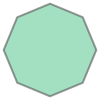

In [13]:
### Jupyter에 Polygon 생성
from shapely.geometry import Polygon
from shapely.wkt import loads
buff=loads(data0[0][0])
buff

<h2> 거리와 주변 <h2>

In [14]:
### 두 포인트 사이의 거리
cursor.execute("SELECT ST_Distance(a.location, b.location) FROM art_pieces a, art_pieces b where a.code='101' AND b.code='102'") 
dist=cursor.fetchall() 
dist

[(11703.61737542573,),
 (11703.617375424448,),
 (11703.617375425392,),
 (11703.617375424112,)]

In [15]:
### 하드 코딩된 포인트와의 거리
cursor.execute("SELECT ST_Distance(ST_Transform(a.location,4326), ST_GeometryFromText('POINT(-106.5 35.1)',4326)) FROM art_pieces a where a.code='101'")
cursor.fetchall()

[(0.1073057472600739,), (0.1073057472600739,)]

In [16]:
### 하드 코딩된 포인트와의 거리
from shapely.geometry import Point 
p=Point(-106.5,35.1) 
cursor.execute("SELECT ST_Distance(ST_Transform(a.location,4326), ST_GeometryFromText('{}',4326)) FROM art_pieces a where a.code='101'".format(p.wkt))
cursor.fetchall()

[(0.1073057472600739,), (0.1073057472600739,)]

In [17]:
### 여러 포인트 사이의 거리(결과: 미터단위)
cursor.execute("SELECT code, ST_Distance(ST_Transform(location,4326), ST_GeometryFromText('POINT(-106.591838300225 35.1555000000615)',4326)) as d from art_pieces LIMIT 5") 
cursor.fetchall()     

[('101', 4.0194366942304644e-14),
 ('102', 0.09553364038303085),
 ('104', 0.0434647235710959),
 ('105', 0.08977908854882373),
 ('106', 0.08136896643867003)]

In [ ]:
### 특정 지점과 가장 가까운 포인트 출력(5개)
cursor.execute("SELECT code, ST_Distance(ST_Transform(location,4326), ST_GeometryFromText('POINT(-106.591838300225 35.1555000000615)',4326)) as d from art_pieces ORDER BY location',4326) LIMIT 5") 
cursor.fetchall()

<h2> 데이터베이스에서의 선 <h2>

In [18]:
### DB에 선 생성
from shapely.geometry import LineString 
from shapely.geometry import MultiLineString
connection = psycopg2.connect(database="pythonspatial",user="postgres",password="****")
cursor = connection.cursor()
cursor.execute("CREATE TABLE lines (id SERIAL PRIMARY KEY, location GEOMETRY)") 
thelines=[] 
thelines.append(LineString([(-106.635585,35.086972),(-106.621294,35.124997)])) 
thelines.append(LineString([(-106.498309,35.140108),(-106.497010,35.069488)])) 
thelines.append(LineString([(-106.663878,35.106459),(-106.586506,35.103979)]))
mls=MultiLineString([((-106.635585,35.086972),(-106.621294,35.124997)),((-106.498309,35.140108),(-106.497010,35.069488)),((-106.663878 ,35.106459),(-106.586506,35.103979))])
for a in thelines:    
    cursor.execute("INSERT INTO lines (location) VALUES (ST_GeomFromText('{}'))".format(a.wkt)) 
    connection.commit() 

In [19]:
### data 확인
cursor.execute("SELECT id, ST_AsTexT(location) from lines") 
data=cursor.fetchall() 
data

[(1, 'LINESTRING(-106.635585 35.086972,-106.621294 35.124997)'),
 (2, 'LINESTRING(-106.498309 35.140108,-106.49701 35.069488)'),
 (3, 'LINESTRING(-106.663878 35.106459,-106.586506 35.103979)')]

<h2> 선의 길이 <h2>

In [20]:
### 선의 길이 반환
cursor.execute("SELECT id, ST_Length(location::geography) FROM lines ") 
cursor.fetchall()

[(1, 4415.2102680810885), (2, 7835.6540540819515), (3, 7059.458405023586)]

In [21]:
### 선의 길이순을 정렬하여 반환
cursor.execute("SELECT id, ST_Length(location::geography) FROM lines ORDER BY ST_Length(location::geography)") 
cursor.fetchall()   

[(1, 4415.2102680810885), (3, 7059.458405023586), (2, 7835.6540540819515)]

<h2> 선 교차하기 <h2>

In [22]:
### 두 선이 교차하는지 확인
cursor.execute("SELECT ST_Intersects(l.location::geography,ll.location::geometry) FROM lines l, lines ll WHERE l.id=1 AND ll.id=3") 
cursor.fetchall()

[(True,)]

In [23]:
### 두 선의 교점 반환
cursor.execute("SELECT ST_AsText(ST_Intersection(l.location::geography, ll.location::geometry)) FROM lines l, lines ll WHERE l.id=1 AND ll.id=3") 
cursor.fetchall()

[('POINT(-106.628684465508 35.1053370957485)',)]

<h2> 폴리곤 <h2>

In [24]:
### DB에 폴리곤 생성
from shapely.geometry import Polygon
connection = psycopg2.connect(database="pythonspatial",user="postgres", password="****") 
cursor = connection.cursor() 
cursor.execute("CREATE TABLE poly (id SERIAL PRIMARY KEY, location GEOMETRY)") 
a=Polygon([(-106.936763,35.958191),(-106.944385,35.239293),(-106.452396,35.281908),(-106.407844,35.948708)]) 
cursor.execute("INSERT INTO poly (location) VALUES (ST_GeomFromText('{}'))".format(a.wkt)) 
connection.commit()

In [25]:
### 폴리곤 영역 반환
cursor.execute("SELECT id, ST_Area(location::geography) from poly")
cursor.fetchall()

[(1, 3550790242.5210876)]

<h2> 폴리곤 내부의 포인트 <h2>

In [26]:
### 폴리곤 내부에 점이 있는지 확인
from shapely.geometry import Point
isin = Point(-106.558743,35.318618) 
cursor.execute("SELECT ST_Contains(polygon.location,ST_GeomFromText('{}')) FROM poly polygon WHERE polygon.id=1".format(isin.wkt)) 
cursor.fetchall()

[(True,)]

In [27]:
### 폴리곤 내부 OR 접하는 점이 있는지 확인
from shapely.geometry import Point
isin=Point(-106.558743,35.318618) 
cursor.execute("SELECT ST_Intersects(ST_GeomFromText('{}')::geography,polygon.location::geometry) FROM poly polygon WHERE polygon.id=1".format(isin.wkt)) 
cursor.fetchall() 

[(True,)]

In [28]:
### 폴리곤과 교차하는 선 확인
from shapely.geometry import LineString
isin=LineString([(-106.55,35.31),(-106.40,35.94)]) 
cursor.execute("SELECT ST_AsText(ST_Intersection(polygon.location,ST_GeomFromText('{}'))) FROM poly polygon WHERE polygon.id=1".format(isin.wkt)) 
cursor.fetchall()

[('LINESTRING(-106.55 35.31,-106.411712640251 35.8908069109443)',)]